<a href="https://colab.research.google.com/github/jung-han-lee/Projects/blob/master/robust_formulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
%matplotlib inline

In [ ]:
start_year = "1970"
end_year = "2009"

In [ ]:
df_factor = pd.read_csv("../data/french_data/FF_Factors_daily.csv", index_col=0, parse_dates=True)[start_year:end_year]/100
df_factor = df_factor[df_factor.columns[:-1]]
df_17 = pd.read_csv("../data/french_data/17_Industry_daily.csv", index_col=0, parse_dates=True)[start_year:end_year]/100
df_38 = pd.read_csv("../data/french_data/38_Industry_daily.csv", index_col=0, parse_dates=True)[start_year:end_year]/100
df_38 = df_38[(df_38 > -0.80) & (df_38 < 0.8)].dropna(axis=1)
df_49 = pd.read_csv("../data/french_data/49_Industry_daily.csv", index_col=0, parse_dates=True)[start_year:end_year]/100
df_49 = df_49[(df_49 > -0.80) & (df_49 < 0.8)].dropna(axis=1)

In [ ]:
df_factor.tail(2)

,Mkt-RF,SMB,HML
2009-12-30,0.0000,-0.0006,-0.0009
2009-12-31,-0.0099,-0.0020,0.0032


In [ ]:
df_17.head(2)

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
1970-01-02,0.0067,0.0263,0.0193,0.0211,-0.0010,0.0159,-0.0013,0.0159,0.0268,-0.0040,0.0082,0.0293,0.0335,0.0163,0.0028,0.0101,0.0117
1970-01-05,0.0035,0.0121,0.0094,0.0179,0.0006,0.0055,0.0022,0.0071,0.0027,0.0044,0.0088,-0.0018,0.0157,0.0126,-0.0036,0.0061,0.0090


# Data
* http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html
* Industry returns(17, 38 and 49)
* 5-yr rebalancing

In [ ]:
cp.installed_solvers()

['CPLEX', 'CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCS']

In [ ]:
def MV_model(data, lam, non_negative=False, verbose=False):
    mu = data.mean() # 수익률 평균
    cov = data.cov() # 
    n = len(data.columns)
    x = cp.Variable(n)
    obj = cp.Minimize(cp.quad_form(x, cov) - lam*cp.matmul(mu.T, x))
    cons = []
    cons.append(cp.sum(x) == 1)
    if non_negative == True:
        cons.append(x >= 0)
    # print("The optimization problem is constructed well.")

    prob = cp.Problem(obj, cons)
    prob.solve(solver=cp.CPLEX, verbose=verbose)
#     print("optimal objetive value: {}".format(prob.value))
#     print(x.value)
    return x.value, np.dot(x.value, mu) * 252, np.sqrt(np.dot(x.value, np.dot(cov * 252, x.value)))

## 1. Mean-Variance efficient frontier : no-constraints.
* lambda as 0.01, 0.03, 0.05, 0.07, 0.09

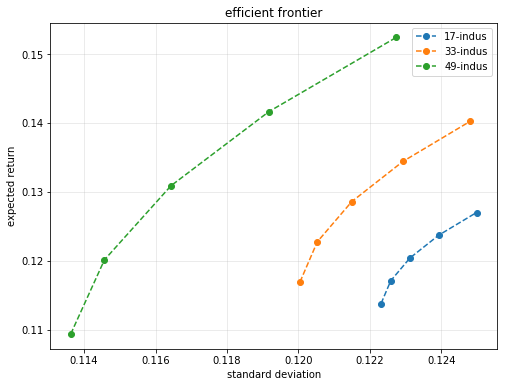

In [ ]:
plt.figure(figsize=(8,6))
for data in [df_17, df_38, df_49]:
    pret = []
    pvol = []
    for lam in [0.01, 0.03, 0.05, 0.07, 0.09]:
        weight, ret, vol = MV_model(data, lam)
        pret.append(ret)
        pvol.append(vol)
    plt.plot(pvol, pret, 'o--', label="{}-indus".format(len(data.columns)))
plt.xlabel("standard deviation")
plt.ylabel("expected return")
plt.title("efficient frontier")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 2. Mean-Variance efficient frontier : no-shorting constraints.
* lambda as 0.01, 0.03, 0.05, 0.07, 0.09

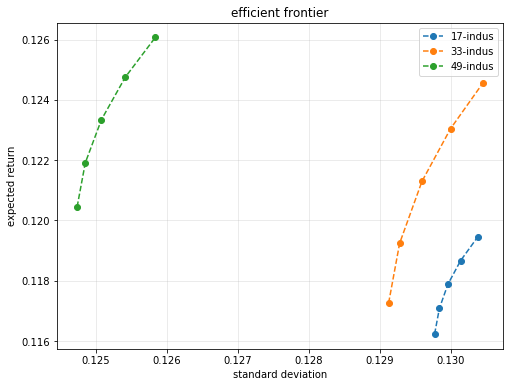

In [ ]:
plt.figure(figsize=(8,6))
for data in [df_17, df_38, df_49]:
    pret = []
    pvol = []
    for lam in [0.01, 0.03, 0.05, 0.07, 0.09]:
        weight, ret, vol = MV_model(data, lam, non_negative=True)
        pret.append(ret)
        pvol.append(vol)
    plt.plot(pvol, pret, 'o--', label="{}-indus".format(len(data.columns)))
plt.xlabel("standard deviation")
plt.ylabel("expected return")
plt.title("efficient frontier")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 3. Box Uncertain Region: no-constraints
* lambda as 0.1
* confidence level = 99% ~ 1%

In [ ]:
def robust_box_model(data, lam, alpha, non_negative=False, verbose=False):
    n, nassets = len(data), len(data.columns)
    mu = data.mean() # 수익률 평균
    std = data.std() # 수익률 표준편차
    cov = data.cov() # 공분산
    
    z = stats.norm.ppf(1 - (1-alpha)/2)
    delta = z * std / np.sqrt(n) # uncertain region
    
    x = cp.Variable(nassets) # 투자 가중치
    obj = cp.Minimize(cp.quad_form(x, cov) - lam * (cp.matmul(mu.T, x) - cp.matmul(delta,cp.abs(x)))) # 목적함수
    cons = [] # 제약식
    cons.append(cp.sum(x) == 1)
    if non_negative == True:
        cons.append(x >= 0)
    # print("The optimization problem is constructed well.")
    prob = cp.Problem(obj, cons)
    prob.solve(solver=cp.CPLEX, verbose=verbose)
#     print("optimal objetive value: {}".format(prob.value))
#     print(x.value)
    return x.value, np.dot(x.value, mu)*252, np.sqrt(cp.quad_form(x,cov*252).value) # 일간 데이터 연율화

## 4. Box Uncertain Region: no-shorting constraints
* The first curve uses return data from 1970 to 1974, the second uses 1975-1979, and so on.
* lambda = 0.1
* confidence level = 99% ~ 1%
* left-bottom point(★) = 99% (Confidence level)

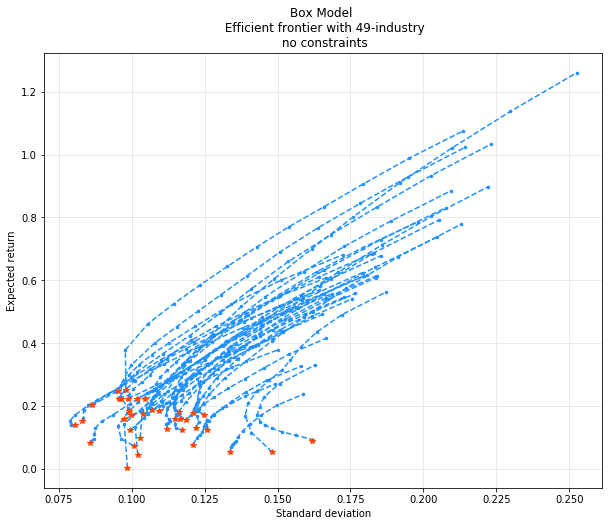

In [ ]:
lam = 0.1
data = df_49
nassets = len(data.columns)
start_year = data.index.year[0]
end_year = data.index.year[-1]
window = 5

plt.figure(figsize=(10,8))
for i in np.arange(start_year, end_year-window+2, 1):
    pret = []
    pvol = []
    for alpha in np.linspace(99, 1, 12):
        alpha = alpha / 100
        weight, ret, vol = robust_box_model(data=data[str(i):str(i+window-1)], lam=lam, alpha=alpha, non_negative=False)
        pret.append(ret)
        pvol.append(vol)

    plt.plot(pvol, pret, 'o--', linewidth=1.5, markersize=2.5, zorder=0, label="{}-yr".format(i), color="dodgerblue")
    plt.plot(pvol[0], pret[0], marker="*", markersize=6, color="orangered")

plt.xlabel("Standard deviation")
plt.ylabel("Expected return")
plt.title("Box Model \n Efficient frontier with {}-industry\n no constraints".format(nassets))
# plt.legend()
plt.grid(alpha=0.3)
plt.show()

### 4-1) 종목 수에 따른 효율적 투자기회선 양상 (Efficient Frontier depends on the number of investment)
- diversification effect 관측

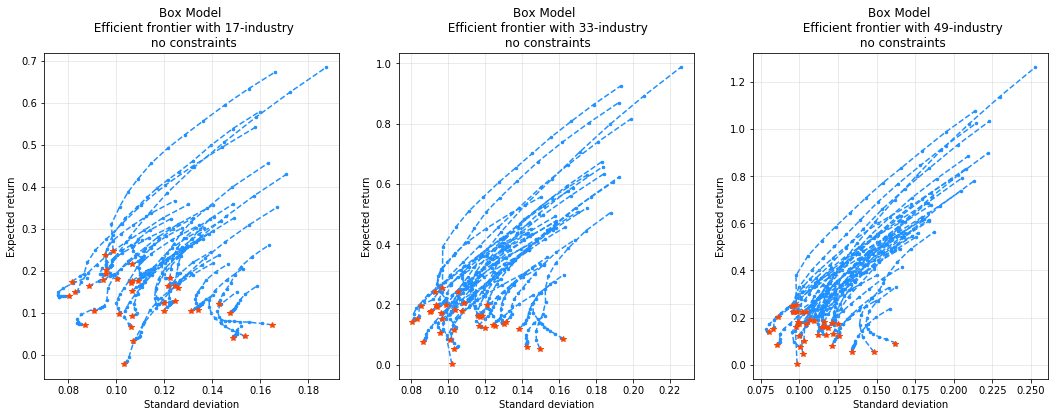

In [ ]:
lam = 0.1
data = [df_17, df_38, df_49]

window = 5

plt.figure(figsize=(18,6))


for nfig, data in enumerate(data):
    plt.subplot(1,3,nfig+1)
    nassets = len(data.columns)
    start_year = data.index.year[0]
    end_year = data.index.year[-1]
    for i in np.arange(start_year, end_year-window+2, 1):
        pret = []
        pvol = []
        for alpha in np.linspace(99, 1, 12):
            alpha = alpha / 100
            weight, ret, vol = robust_box_model(data=data[str(i):str(i+window-1)], lam=lam, alpha=alpha, non_negative=False)
            pret.append(ret)
            pvol.append(vol)

        plt.plot(pvol, pret, 'o--', linewidth=1.5, markersize=2.5, zorder=0, label="{}-yr".format(i), color="dodgerblue")
        plt.plot(pvol[0], pret[0], marker="*", markersize=6, color="orangered")

    plt.xlabel("Standard deviation")
    plt.ylabel("Expected return")
    plt.title("Box Model \n Efficient frontier with {}-industry\n no constraints".format(nassets))
    # plt.legend()
    plt.grid(alpha=0.3)
plt.show()

## 5. Ellipsodial Uncertain Region: no-constraints
* The first curve uses return data from 1970 to 1974, the second uses 1975-1979, and so on.
* lambda = 0.1
* confidence level = 99% ~ 1%
* left-bottom point(★) = 99% (Confidence level)

In [ ]:
def robust_ellipsoidal_model(data, lam, alpha, non_negative, verbose=False):
    n, nassets = len(data), len(data.columns)
    mu = data.mean()
    
    cov = data.cov()
    covmu = cov/n
    sqrtcovmu = sp.linalg.sqrtm(covmu)
    
    delta = np.sqrt(stats.chi2.ppf(alpha, nassets))

    x = cp.Variable(nassets)
    obj = cp.Minimize(cp.quad_form(x,cov) - lam * cp.matmul(mu.T, x) + lam * delta * (cp.norm2(sqrtcovmu@x)))
    cons = []
    cons.append(cp.sum(x) == 1)
    if non_negative == True:
        cons.append(x >= 0)
        
    prob = cp.Problem(obj, cons)
    prob.solve(solver=cp.CPLEX, verbose=verbose)
#     print(x.value)
    return x.value, np.dot(x.value, mu) * 252, np.sqrt(np.dot(x.value, np.dot(cov*252, x.value)))

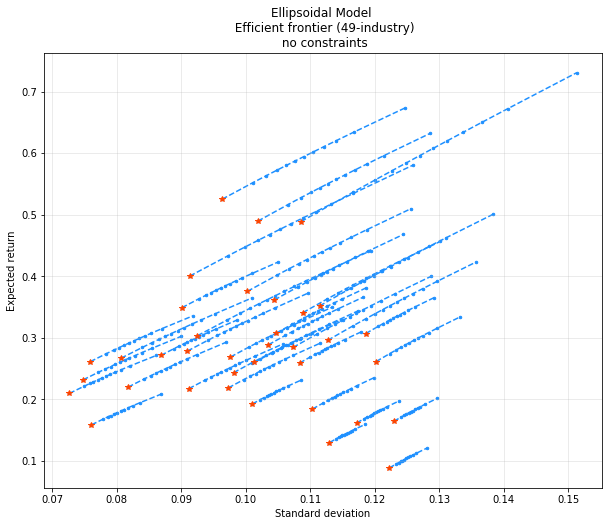

In [ ]:
lam = 0.1
data = df_49
start_year = data.index.year[0]
end_year = data.index.year[-1]
nassets = len(data.columns)
window = 5

plt.figure(figsize=(10,8))
for i in np.arange(start_year, end_year-window+2, 1):
    pret = []
    pvol = []
    for alpha in np.linspace(99, 1, 12):
        alpha = alpha / 100
        weight, ret, vol = robust_ellipsoidal_model(data=data[str(i):str(i+window-1)], lam=lam, alpha=alpha, non_negative=False)
        pret.append(ret)
        pvol.append(vol)

    plt.plot(pvol, pret, 'o--', linewidth = 1.5, markersize=2.5, zorder=0, label="{}-yr".format(i), color="dodgerblue")
    plt.plot(pvol[0], pret[0], marker="*", markersize=6, color="orangered")

plt.xlabel("Standard deviation")
plt.ylabel("Expected return")
plt.title("Ellipsoidal Model \n Efficient frontier ({}-industry)\n no constraints".format(nassets))
# plt.legend()
plt.grid(alpha=0.3)
plt.show()

### 5-1) 종목 수에 따른 효율적 투자기회선 양상 (Efficient Frontier depends on the number of investment)

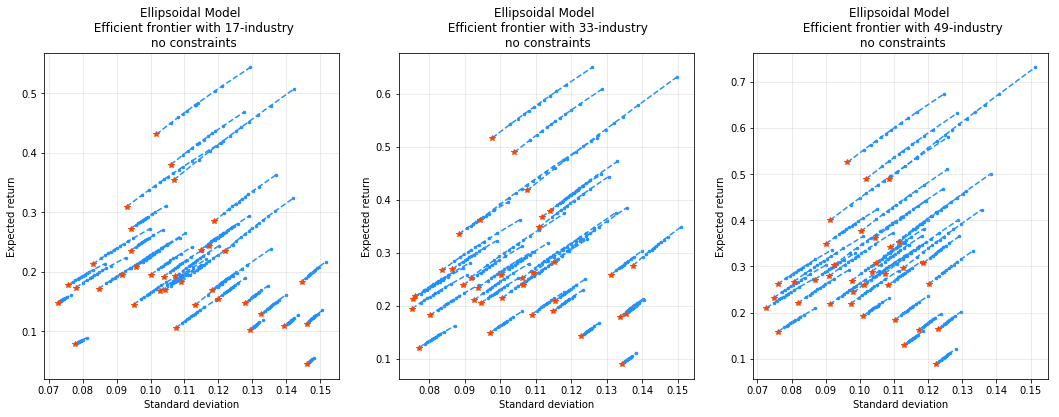

In [ ]:
lam = 0.1
data = [df_17, df_38, df_49]

window = 5

plt.figure(figsize=(18,6))
for nfig, data in enumerate(data):
    plt.subplot(1,3,nfig+1)
    nassets = len(data.columns)
    start_year = data.index.year[0]
    end_year = data.index.year[-1]
    for i in np.arange(start_year, end_year-window+2, 1):
        pret = []
        pvol = []
        for alpha in np.linspace(99, 1, 12):
            alpha = alpha / 100
            weight, ret, vol = robust_ellipsoidal_model(data=data[str(i):str(i+window-1)], lam=lam, alpha=alpha, non_negative=False)
            pret.append(ret)
            pvol.append(vol)

        plt.plot(pvol, pret, 'o--', linewidth=1.5, markersize=2.5, zorder=0, label="{}-yr".format(i), color="dodgerblue")
        plt.plot(pvol[0], pret[0], marker="*", markersize=6, color="orangered")
  
    plt.xlabel("Standard deviation")
    plt.ylabel("Expected return")
    plt.title("Ellipsoidal Model \n Efficient frontier with {}-industry\n no constraints".format(nassets))
    plt.grid(alpha=0.3)
plt.show()